```
From: https://github.com/ksatola
Version: 0.0.1

TODOs
1. 

```

# Feature Selection - Ex - Regression

## Table of Contents

Feature Selection (this Notebook):
- [Regression Dataset](#)
- XXXX dokonczyc
- [Introduction](#intro)
    - Cross Validation
    - Methods
- [Feature Selection Checklist](#check)


In [1]:
# Connect with underlying Python code
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

In [2]:
from datasets import (
    get_dataset
)

from feature_selection import (
    select_features
)

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [4]:
import sklearn
print(sklearn.__version__)

0.23.2


---
<a id='intro'></a>

## Regression Dataset
The [make_regression()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html) function from the scikit-learn library can be used to define a dataset. It provides control over the number of samples, number of input features, and, importantly, the number of relevant and redundant input features. This is critical as we specifically desire a dataset that we know has some redundant input features.

We will define a dataset with 1,000 samples, each with 100 input features where 10 are informative and the remaining 90 are redundant.

In [5]:
# load and summarize the dataset
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, noise=0.1, random_state=1)

In [6]:
X_df = pd.DataFrame(X)#, columns = ['Column_A','Column_B','Column_C'])
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.308937,-1.358117,1.799673,0.370344,-1.089044,-0.611431,-0.335119,1.147323,-1.054796,0.139363,...,-0.450311,-0.015725,-0.080910,-0.809523,-0.615246,0.251029,-0.161305,-0.552200,-1.508041,0.149237
1,-0.714677,-0.911399,0.704543,0.072666,-0.146416,-1.417644,-0.267344,0.963182,1.159643,-0.782204,...,1.002065,-1.594992,1.299482,0.285062,0.109400,0.049349,1.239483,-0.770401,0.497540,0.836287
2,-2.414273,0.270416,-1.890207,-0.984467,-0.509132,-0.236473,0.924821,-1.554528,0.220635,-1.079696,...,-0.240047,1.455053,-0.853952,0.227808,-1.869735,0.606788,-0.503986,0.434974,0.967623,1.107183
3,1.537630,-0.936710,0.922793,-0.003897,-1.335670,-0.665940,0.716759,-0.155484,1.408668,2.234314,...,0.171679,-2.075227,0.357591,-0.653531,-0.516247,-1.373571,0.145010,1.631103,-1.623318,1.773253
4,-0.484542,1.470649,1.364323,-0.467492,1.580360,-0.009018,0.412203,0.587010,-0.461107,-0.079273,...,-0.292875,-1.347707,-0.473457,-0.345626,-0.040660,-1.085091,0.174213,-0.919603,-0.324808,0.019620


In [7]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [8]:
# Summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (670, 100) (670,)
Test (330, 100) (330,)


## Numerical Feature Selection

Low variance:
- **Remove features with low variance**

Univariate feature selection:
- **Correlation Feature Selection:** Correlation is a measure of how two variables change together. Perhaps the most common correlation measure is Pearson’s correlation that assumes a Gaussian distribution to each variable and reports on their linear relationship.
- **Mutual Information Feature Selection:** Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable.

Recursive feature elimination:
- XXX

### Remove features with low variance
VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.

As an example, suppose that we have a dataset with boolean features, and we want to remove all features that are either one or zero (on or off) in more than 80% of the samples. Boolean features are Bernoulli random variables, and the variance of such variables is given by
```
Var[X] = p(1-p)
```
so we can select using the threshold .8 * (1 - .8).

In [9]:
.8 * (1 - .8)

0.15999999999999998

In [10]:
from sklearn.feature_selection import VarianceThreshold

X1 = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X1)

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

In [11]:
# Just make a convenience function; this one wraps the VarianceThreshold
# transformer but you can pass it a pandas dataframe and get one in return
# https://stackoverflow.com/questions/29298973/removing-features-with-low-variance-using-scikit-learn

def get_low_variance_columns(dframe=None, columns=None,
                             skip_columns=None, thresh=0.0,
                             autoremove=False):
    """
    Wrapper for sklearn VarianceThreshold for use on pandas dataframes.
    """
    print("Finding low-variance features.")
    try:
        # get list of all the original df columns
        all_columns = dframe.columns

        # remove `skip_columns`
        remaining_columns = all_columns.drop(skip_columns)

        # get length of new index
        max_index = len(remaining_columns) - 1

        # get indices for `skip_columns`
        skipped_idx = [all_columns.get_loc(column)
                       for column
                       in skip_columns]

        # adjust insert location by the number of columns removed
        # (for non-zero insertion locations) to keep relative
        # locations intact
        for idx, item in enumerate(skipped_idx):
            if item > max_index:
                diff = item - max_index
                skipped_idx[idx] -= diff
            if item == max_index:
                diff = item - len(skip_columns)
                skipped_idx[idx] -= diff
            if idx == 0:
                skipped_idx[idx] = item

        # get values of `skip_columns`
        skipped_values = dframe.iloc[:, skipped_idx].values

        # get dataframe values
        X = dframe.loc[:, remaining_columns].values

        # instantiate VarianceThreshold object
        vt = VarianceThreshold(threshold=thresh)

        # fit vt to data
        vt.fit(X)

        # get the indices of the features that are being kept
        feature_indices = vt.get_support(indices=True)

        # remove low-variance columns from index
        feature_names = [remaining_columns[idx]
                         for idx, _
                         in enumerate(remaining_columns)
                         if idx
                         in feature_indices]

        # get the columns to be removed
        removed_features = list(np.setdiff1d(remaining_columns,
                                             feature_names))
        print("Found {0} low-variance columns."
              .format(len(removed_features)))

        # remove the columns
        if autoremove:
            print("Removing low-variance features.")
            # remove the low-variance columns
            X_removed = vt.transform(X)

            print("Reassembling the dataframe (with low-variance "
                  "features removed).")
            # re-assemble the dataframe
            dframe = pd.DataFrame(data=X_removed,
                                  columns=feature_names)

            # add back the `skip_columns`
            for idx, index in enumerate(skipped_idx):
                dframe.insert(loc=index,
                              column=skip_columns[idx],
                              value=skipped_values[:, idx])
            print("Succesfully removed low-variance columns.")

        # do not remove columns
        else:
            print("No changes have been made to the dataframe.")

    except Exception as e:
        print(e)
        print("Could not remove low-variance features. Something "
              "went wrong.")
        pass

    return dframe, removed_features

In [12]:
df = pd.DataFrame(X_train)#, columns = ['Column_A','Column_B','Column_C'])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-1.871971,-0.291231,0.902389,-0.869972,0.979617,-1.481788,0.074030,0.379316,-0.656935,0.317963,...,1.245430,-0.723215,0.169526,0.487529,-0.248418,0.827471,-1.259159,1.355173,0.720103,1.332368
1,1.220610,-0.123730,0.985174,-0.010736,-0.022537,0.313770,1.470754,-1.306269,1.581214,-0.981034,...,-0.889007,0.305280,-1.030287,0.346769,-0.924873,0.676581,0.577162,0.408939,-0.836799,0.786225
2,-1.494456,-0.553212,1.305315,-0.809376,1.467617,-0.681215,-0.771241,1.261611,-1.097849,0.712218,...,-0.671565,0.195052,0.960592,-0.799993,0.570993,0.056986,-0.286504,-1.681562,-0.305025,0.452569
3,0.900339,-0.935345,-0.192279,1.289228,0.925454,-1.165921,-0.562240,0.950477,-1.316410,-0.259530,...,-0.917765,0.817614,-0.730616,0.304676,-1.410802,-0.169603,-0.625380,-0.532919,-0.432969,-0.981493
4,0.033686,-2.041298,-2.634345,-1.545732,-0.604669,0.088849,-0.899741,-0.366217,0.601805,-0.240145,...,0.876640,-0.340806,-1.490400,0.068468,0.399456,-1.260501,-0.223374,0.137358,-0.881357,-0.672122


In [13]:
get_low_variance_columns(dframe=df, columns=df.columns, skip_columns=[], thresh=0.0, autoremove=False)

Finding low-variance features.
Found 0 low-variance columns.
No changes have been made to the dataframe.


(           0         1         2         3         4         5         6   \
 0   -1.871971 -0.291231  0.902389 -0.869972  0.979617 -1.481788  0.074030   
 1    1.220610 -0.123730  0.985174 -0.010736 -0.022537  0.313770  1.470754   
 2   -1.494456 -0.553212  1.305315 -0.809376  1.467617 -0.681215 -0.771241   
 3    0.900339 -0.935345 -0.192279  1.289228  0.925454 -1.165921 -0.562240   
 4    0.033686 -2.041298 -2.634345 -1.545732 -0.604669  0.088849 -0.899741   
 ..        ...       ...       ...       ...       ...       ...       ...   
 665  1.204892  1.199805 -1.501007 -0.257250 -0.360571 -1.430155  0.434164   
 666 -0.820832  1.533342 -0.504243 -0.060644 -0.669185  0.884871  0.601132   
 667  0.746176  0.354306 -0.626249  0.981839  0.374672 -0.530459 -0.600365   
 668 -0.498498  1.514459 -1.094931  0.188624 -0.936138 -1.431263 -1.003676   
 669  0.452704  0.317291  0.645293 -0.766670  0.223224 -0.625196 -0.727168   
 
            7         8         9   ...        90        91   

### Correlation Feature Selection
Linear correlation scores are typically a value between -1 and 1 with 0 representing no relationship. `For feature selection, we are often interested in a positive score with the larger the positive value`, the larger the relationship, and, more likely, the feature should be selected for modeling. As such the linear correlation can be converted into a correlation statistic with only positive values.

The scikit-learn machine library provides an implementation of the correlation statistic in the [f_regression()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html) function. This function can be used in a feature selection strategy, such as selecting the top k most relevant features (largest values) via the [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) class.

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# Feature selection
def select_features(X_train, y_train, X_test, score_func):
    
    # Configure to select all features
    fs = SelectKBest(score_func=score_func, k='all')
    
    # Learn relationship from training data
    fs.fit(X_train, y_train)
    
    # Transform train input data
    X_train_fs = fs.transform(X_train)
    
    # Transform test input data
    X_test_fs = fs.transform(X_test)

    return X_train_fs, X_test_fs, fs

In [18]:
# Feature selection
X_train_fs, X_test_fs, fs = select_features(X_train=X_train, y_train=y_train, X_test=X_test, score_func=f_regression)

########## Zrobic dataframe i powiazac scoring z nazwami kolumn, teraz to jest niepowiazane
sorted_results = np.sort(fs.scores_)[::-1] # descending order

# What are scores for the features
for i in range(len(sorted_results[:15])):
    print(f'Feature {i:02}: {sorted_results[i]:>8.2f}')

Feature 00:   231.89
Feature 01:   198.71
Feature 02:   122.13
Feature 03:   101.39
Feature 04:    63.96
Feature 05:    52.20
Feature 06:    45.74
Feature 07:    13.95
Feature 08:     9.57
Feature 09:     5.99
Feature 10:     5.96
Feature 11:     5.72
Feature 12:     5.59
Feature 13:     5.36
Feature 14:     4.30


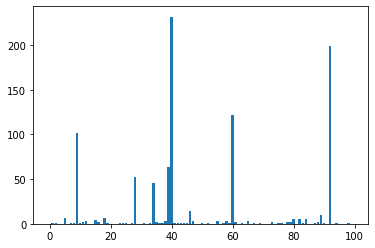

In [31]:
# Bar Chart of the Input Features (x) vs. Correlation Feature Importance (y)
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

### Mutual Information Feature Selection
**Mutual information** from the field of information theory is the application of information gain (typically used in the construction of decision trees) to feature selection. Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable.

Mutual information is straightforward when considering the distribution of two discrete (categorical or ordinal) variables, such as categorical input and categorical output data. Nevertheless, it can be adapted for use with numerical input and output data. See [Mutual Information between Discrete and Continuous Data Sets'](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3929353/).

The scikit-learn machine learning library provides an implementation of mutual information for feature selection with numeric input and output variables via the [mutual_info_regression()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) function.

In [75]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [76]:
# example of mutual information feature selection for numerical input data
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# Feature selection
X_train_fs, X_test_fs, fs = select_features(X_train=X_train, y_train=y_train, X_test=X_test, score_func=f_regression)

In [77]:
sorted_results = np.sort(fs.scores_)[::-1] # descending order

# What are scores for the features
for i in range(len(sorted_results[:15])):
    print(f'Feature {i:02}: {sorted_results[i]:>8.2f}')

Feature 00:   231.89
Feature 01:   198.71
Feature 02:   122.13
Feature 03:   101.39
Feature 04:    63.96
Feature 05:    52.20
Feature 06:    45.74
Feature 07:    13.95
Feature 08:     9.57
Feature 09:     5.99
Feature 10:     5.96
Feature 11:     5.72
Feature 12:     5.59
Feature 13:     5.36
Feature 14:     4.30


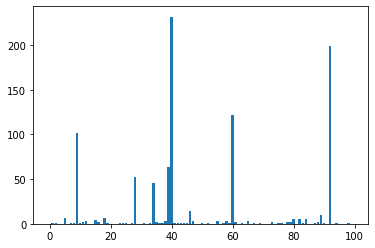

In [78]:
# Bar Chart of the Input Features (x) vs. Correlation Feature Importance (y)
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

## Feature selection using SelectFromModel and LassoCV
[Use SelectFromModel meta-transformer along with Lasso to select the best couple of features from the diabetes dataset](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py).

Since the `L1 norm` promotes sparsity of features we might be interested in selecting only a subset of the most interesting features from the dataset. This example shows how to select two the most interesting features from the diabetes dataset.

Diabetes dataset consists of 10 variables (features) collected from 442 diabetes patients. This example shows how to use SelectFromModel and LassoCv to find the best two features predicting disease progression after one year from the baseline.

In [5]:
from sklearn.datasets import load_diabetes
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

In [6]:
diabetes = load_diabetes()

X = diabetes.data
y = diabetes.target

feature_names = diabetes.feature_names
print(feature_names)

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


To decide on the importance of the features we are going to use `LassoCV` estimator. The features with the highest absolute `coef_` value are considered the most important.

In [10]:
clf = LassoCV().fit(X, y)
importance = np.abs(clf.coef_)
print(importance)

[  6.49684455 235.99640534 521.73854261 321.06689245 569.4426838
 302.45627915   0.         143.6995665  669.92633112  66.83430445]


Now we want to select the two features which are the most important. `SelectFromModel()` allows for setting the threshold. Only the features with the `coef_` higher than the threshold will remain. Here, we want to set the threshold slightly above the third highest `coef_` calculated by `LassoCV()` from our data.

In [11]:
idx_third = importance.argsort()[-3]
threshold = importance[idx_third] + 0.01

idx_features = (-importance).argsort()[:2]
name_features = np.array(feature_names)[idx_features]
print('Selected features: {}'.format(name_features))

Selected features: ['s5' 's1']


In [18]:
sfm = SelectFromModel(clf, threshold=threshold)
sfm.fit(X, y)
X_transform = sfm.transform(X)

n_features = sfm.transform(X).shape[1]
n_features

2

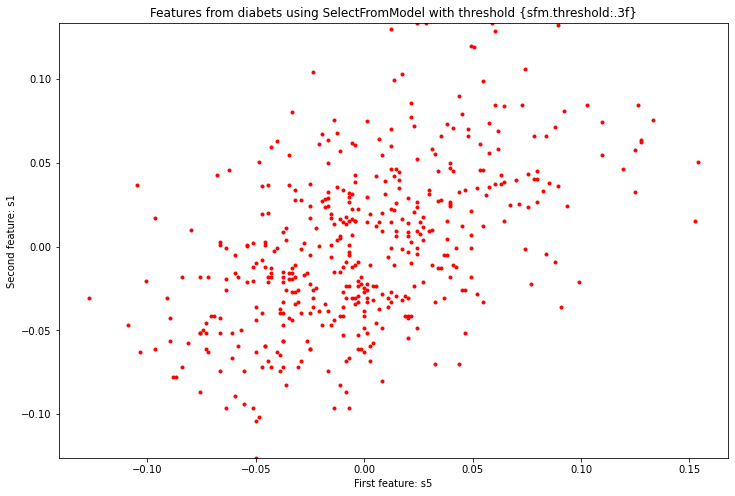

In [20]:
# Plot the selected two features from the data
fig, ax = plt.subplots(figsize=(12, 8))
plt.title(
    "Features from diabets using SelectFromModel with "
    "threshold {sfm.threshold:.3f}")
feature1 = X_transform[:, 0]
feature2 = X_transform[:, 1]
plt.plot(feature1, feature2, 'r.')
plt.xlabel("First feature: {}".format(name_features[0]))
plt.ylabel("Second feature: {}".format(name_features[1]))
plt.ylim([np.min(feature2), np.max(feature2)])
plt.show()

## Feature importances with forests of trees
[This example](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py) shows the use of forests of trees to evaluate the importance of features on an artificial classification task. The red bars are the impurity-based feature importances of the forest, along with their inter-trees variability.

As expected, the plot suggests that 3 features are informative, while the remaining are not.

**Warning:** impurity-based feature importances can be misleading for high cardinality features (many unique values). See [sklearn.inspection.permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance) as an alternative.

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

In [22]:
# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

In [23]:
# Build a forest and compute the impurity-based feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [24]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 1 (0.295902)
2. feature 2 (0.208351)
3. feature 0 (0.177632)
4. feature 3 (0.047121)
5. feature 6 (0.046303)
6. feature 8 (0.046013)
7. feature 7 (0.045575)
8. feature 4 (0.044614)
9. feature 9 (0.044577)
10. feature 5 (0.043912)


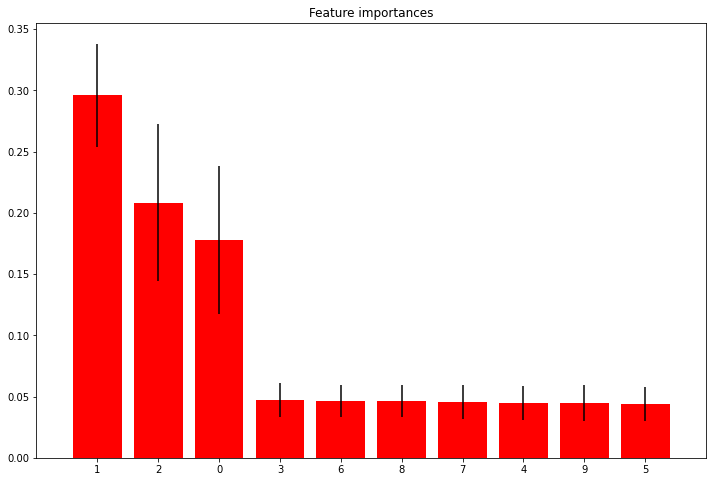

In [25]:
# Plot the impurity-based feature importances of the forest
fig, ax = plt.subplots(figsize=(12, 8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## Modeling With Selected Features
A robust approach is to evaluate models using different feature selection methods (and numbers of features) and select the method that results in a model with the best performance. Linear regression is a good model for testing feature selection methods as it can perform better if irrelevant features are removed from the model.

### Model Built Using All Features

In [19]:
# Evaluation of a model using all input features
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Load the dataset
X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, noise=0.1, random_state=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
yhat = model.predict(X_test)

# Evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

MAE: 0.086


### Model Built Using Correlation Features

In [20]:
# Evaluation of a model using 10 features chosen with correlation
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Feature selection
def select_features(X_train, y_train, X_test):
    # configure to select a subset of features
    fs = SelectKBest(score_func=f_regression, k=10)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# Load the dataset
X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, noise=0.1, random_state=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# Fit the model
model = LinearRegression()
model.fit(X_train_fs, y_train)

# Evaluate the model
yhat = model.predict(X_test_fs)

# Evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

MAE: 2.740


In this case, we see that the model achieved an error score of about 2.7, which is much larger than the baseline model that used all features and achieved an MAE of 0.086.

This suggests that although the method has a strong idea of what features to select, building a model from these features alone does not result in a more skillful model. This could be because features that are important to the target are being left out, meaning that the method is being deceived about what is important.

### Model Built Using Mutual Information Features
Running the example fits the model on the 88 top selected features chosen using mutual information.

In [21]:
# Evaluation of a model using 88 features chosen with mutual information
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select a subset of features
    fs = SelectKBest(score_func=mutual_info_regression, k=88)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# Load the dataset
X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, noise=0.1, random_state=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# Fit the model
model = LinearRegression()
model.fit(X_train_fs, y_train)

# Evaluate the model
yhat = model.predict(X_test_fs)

# Evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

MAE: 0.084


In this case, we can see a further reduction in error as compared to the correlation statistic, in this case, achieving a MAE of about 0.084.

## Tune the Number of Selected Features
In the previous example, we selected 88 features, but how do we know that is a good or best number of features to select?

Instead of guessing, we can systematically test a range of different numbers of selected features and discover which results in the best performing model. This is called a grid search, where the k argument to the SelectKBest class can be tuned.

It is a good practice to evaluate model configurations on regression tasks using repeated stratified k-fold cross-validation. We will use three repeats of 10-fold cross-validation via the RepeatedKFold class.

We can define a Pipeline that correctly prepares the feature selection transform on the training set and applies it to the train set and test set for each fold of the cross-validation.

In this case, we will use the mutual information statistical method for selecting features. 

We can then define the grid of values to evaluate as 80 to 100.

Note that the grid is a dictionary mapping of parameter-to-values to search, and given that we are using a Pipeline, we can access the SelectKBest object via the name we gave it ‘sel‘ and then the parameter name ‘k‘ separated by two underscores, or ‘sel__k‘.

In this case, we will evaluate models using the negative mean absolute error (neg_mean_absolute_error). It is negative because the scikit-learn requires the score to be maximized, so the MAE is made negative, meaning scores scale from -infinity to 0 (best).

In [22]:
# Compare different numbers of features selected using mutual information
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define dataset
X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, noise=0.1, random_state=1)

# Define the evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Define the pipeline to evaluate
model = LinearRegression()
fs = SelectKBest(score_func=mutual_info_regression)
pipeline = Pipeline(steps=[
    ('sel',fs), 
    ('lr', model),
])

# Define the grid
grid = dict()
grid['sel__k'] = [i for i in range(X.shape[1]-20, X.shape[1]+1)]

# Define the grid search
search = GridSearchCV(pipeline, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)

# Perform the search
results = search.fit(X, y)

# Summarize best
print('Best MAE: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)

# Summarize all
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))

Best MAE: -0.010
Best Config: {'sel__k': 81}
>-50.101 with: {'sel__k': 80}
>-0.010 with: {'sel__k': 81}
>-0.010 with: {'sel__k': 82}
>-0.010 with: {'sel__k': 83}
>-0.010 with: {'sel__k': 84}
>-0.010 with: {'sel__k': 85}
>-0.010 with: {'sel__k': 86}
>-0.010 with: {'sel__k': 87}
>-0.010 with: {'sel__k': 88}
>-0.010 with: {'sel__k': 89}
>-0.010 with: {'sel__k': 90}
>-0.011 with: {'sel__k': 91}
>-0.011 with: {'sel__k': 92}
>-0.011 with: {'sel__k': 93}
>-0.011 with: {'sel__k': 94}
>-0.011 with: {'sel__k': 95}
>-0.011 with: {'sel__k': 96}
>-0.011 with: {'sel__k': 97}
>-0.011 with: {'sel__k': 98}
>-0.011 with: {'sel__k': 99}
>-0.011 with: {'sel__k': 100}


Running the example grid searches different numbers of selected features using mutual information statistics, where each modeling pipeline is evaluated using repeated cross-validation.

In this case, we can see that the best number of selected features is 81, which achieves a MAE of about 0.01 (ignoring the sign).

We might want to see the relationship between the number of selected features and MAE. In this relationship, we may expect that more features result in better performance, to a point.

This relationship can be explored by manually evaluating each configuration of k for the SelectKBest from 81 to 100, gathering the sample of MAE scores, and plotting the results using box and whisker plots side by side. The spread and mean of these box plots would be expected to show any interesting relationship between the number of selected features and the MAE of the pipeline.

Note that we started the spread of k values at 81 instead of 80 because the distribution of MAE scores for k=80 is dramatically larger than all other values of k considered and it washed out the plot of the results on the graph.

>81 -0.082 (0.006)
>82 -0.082 (0.006)
>83 -0.082 (0.006)
>84 -0.082 (0.006)
>85 -0.082 (0.006)
>86 -0.082 (0.006)
>87 -0.082 (0.006)
>88 -0.082 (0.006)
>89 -0.083 (0.006)
>90 -0.083 (0.006)
>91 -0.083 (0.006)
>92 -0.083 (0.006)
>93 -0.083 (0.006)
>94 -0.083 (0.006)
>95 -0.083 (0.006)
>96 -0.083 (0.006)
>97 -0.083 (0.006)
>98 -0.083 (0.006)
>99 -0.083 (0.006)
>100 -0.083 (0.006)


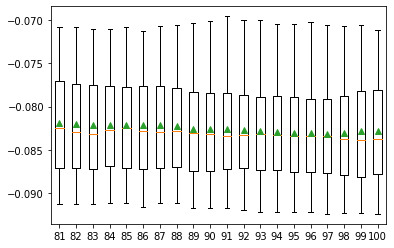

In [25]:
# Compare different numbers of features selected using mutual information
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib inline

# Define dataset
X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, noise=0.1, random_state=1)

# Define number of features to evaluate
num_features = [i for i in range(X.shape[1]-19, X.shape[1]+1)]

# Enumerate each number of features
results = list()
for k in num_features:
    # create pipeline
    model = LinearRegression()
    fs = SelectKBest(score_func=mutual_info_regression, k=k)
    pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])
    # evaluate the model
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    results.append(scores)
    # summarize the results
    print('>%d %.3f (%.3f)' % (k, mean(scores), std(scores)))

# Plot model performance for comparison
plt.boxplot(results, labels=num_features, showmeans=True)
plt.show()

Running the example first reports the mean and standard deviation MAE for each number of selected features. Box and whisker plots are created side by side showing the trend of k vs. MAE where the green triangle represents the mean and orange line represents the median of the distribution.